In [7]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, DataStructs
import numpy as np
from sklearn.model_selection import train_test_split

In [8]:
df = pd.read_csv('data/delaney-processed.csv')
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [9]:
FP_SIZE = 2048

# Convert SMILES to RDKit Mol objects
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)

# Generate Morgan fingerprints
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
def generate_fingerprints(mol):
    if mol is None:
        return np.zeros(FP_SIZE, dtype=np.int8)
    fp = fpgen.GetFingerprint(mol)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr
df['fingerprint'] = df['mol'].apply(generate_fingerprints)

df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol,fingerprint
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x710a8e1dbd10>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x710a8e1dbd80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x710a8e1dbdf0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x710a8e1dbe60>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x710a8e1dbed0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [10]:
# Generate feature matrix and target vector
X = np.array(list(df['fingerprint']))
y = df['measured log solubility in mols per litre'].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

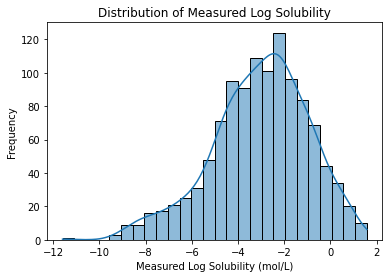

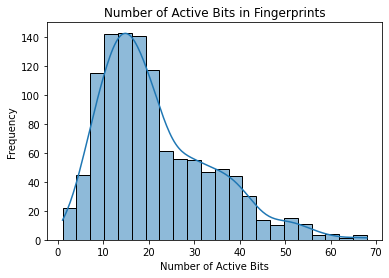

In [11]:
# EDA analysis
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(y, kde=True)
plt.title('Distribution of Measured Log Solubility')
plt.xlabel('Measured Log Solubility (mol/L)')
plt.ylabel('Frequency')
plt.show()

# Number of active bits per molecule
active_bits = [fp.sum() for fp in X]
sns.histplot(active_bits, kde=True)
plt.title('Number of Active Bits in Fingerprints')
plt.xlabel('Number of Active Bits')
plt.ylabel('Frequency')
plt.show()

In [12]:
# Baseline model

# 1) Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest - MSE: {mse_rf:.3f}, R^2: {r2_rf:.3f}')

Random Forest - MSE: 1.421, R^2: 0.696


In [13]:
# 2) XGBoost
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBoost - MSE: {mse_xgb:.3f}, R^2: {r2_xgb:.3f}')

XGBoost - MSE: 1.279, R^2: 0.726


In [14]:
# 3) Extra: LightGBM

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import root_mean_squared_error

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'LightGBM RMSE: {rmse:.4f}')

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.91717	valid_1's rmse: 1.20479
[200]	training's rmse: 0.743471	valid_1's rmse: 1.14499
[300]	training's rmse: 0.654515	valid_1's rmse: 1.12976
[400]	training's rmse: 0.596266	valid_1's rmse: 1.12151
[500]	training's rmse: 0.554611	valid_1's rmse: 1.12022
Early stopping, best iteration is:
[472]	training's rmse: 0.565196	valid_1's rmse: 1.11723
LightGBM RMSE: 1.1172


In [16]:
import pandas as pd
from rdkit import Chem
from deepchem.feat import MolGraphConvFeaturizer

df = pd.read_csv('data/delaney-processed.csv')
featurizer = MolGraphConvFeaturizer()

valid_smiles = []
valid_targets = []

for idx, row in df.iterrows():
    mol = Chem.MolFromSmiles(row['smiles'])
    if mol is None:
        print(f"Invalid SMILES at index {idx}: {row['smiles']}")
        continue
    if mol.GetNumAtoms() < 2:
        print(f"Skipping single-atom molecule at index {idx}: {row['smiles']}")
        continue
    
    try:
        feat = featurizer.featurize([row['smiles']])
        _ = feat[0]
        valid_smiles.append(row['smiles'])
        valid_targets.append(row['measured log solubility in mols per litre'])
    except Exception as e:
        print(f"Failed to featurize at index {idx}: {row['smiles']}. Exception: {e}")

# Save filtered dataset
df_valid = pd.DataFrame({
    'smiles': valid_smiles,
    'measured log solubility in mols per litre': valid_targets
})

df_valid.to_csv('data/delaney-processed-valid.csv', index=False)

print(f"Filtered dataset size: {len(df_valid)}")


Skipping single-atom molecule at index 934: C
Filtered dataset size: 1127


In [17]:
import deepchem as dc
from deepchem.models import GraphConvModel

# Featurizer
featurizer = dc.feat.MolGraphConvFeaturizer()

# Loader
loader = dc.data.CSVLoader(
    tasks=['measured log solubility in mols per litre'],
    smiles_field='smiles',
    featurizer=dc.feat.ConvMolFeaturizer()
)
dataset = loader.create_dataset('data/delaney-processed-valid.csv')

# Split
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset, frac_train=0.75)

# Model
model = GraphConvModel(n_tasks=1, mode='regression', model_dir='model')

# Train
model.fit(train_dataset, nb_epoch=30)

# Metric
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)

# Evaluate
train_score = model.evaluate(train_dataset, [metric])
test_score = model.evaluate(test_dataset, [metric])

print("GNN Train MSE:", train_score)
print("GNN Test MSE:", test_score)

smiles_field is deprecated and will be removed in a future version of DeepChem.Use feature_field instead.
[12:12:32] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:12:32] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:12:32] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:12:32] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:12:32] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:12:32] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:12:32] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:12:32] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:12:32] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:12:32] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:12:32] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:12:32] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[12:12:32] DEPRECA

GNN Train MSE: {'mean_squared_error': 1.070539215821272}
GNN Test MSE: {'mean_squared_error': 1.4175444455701842}
